Importo la librería pandas, cargo dataset, reviso informacion general y el nombre de las columnas para ver los datos que tengo y ver valores nulos.



---



In [1]:
import pandas as pd

ruta = "/content/Baby_5.json"

df = pd.read_json(ruta, lines=True)
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5,Awesine,1373932800,"07 16, 2013"
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5,Should be required for all new parents!,1372464000,"06 29, 2013"
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5,Grandmother watching baby,1395187200,"03 19, 2014"
3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5,repeat buyer,1376697600,"08 17, 2013"
4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4,Great,1396310400,"04 1, 2014"


In [2]:
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160792 entries, 0 to 160791
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      160792 non-null  object
 1   asin            160792 non-null  object
 2   reviewerName    159427 non-null  object
 3   helpful         160792 non-null  object
 4   reviewText      160792 non-null  object
 5   overall         160792 non-null  int64 
 6   summary         160792 non-null  object
 7   unixReviewTime  160792 non-null  int64 
 8   reviewTime      160792 non-null  object
dtypes: int64(2), object(7)
memory usage: 11.0+ MB


Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Aquí transformo la valoración numérica overall en una etiqueta de sentimiento binaria. Considero como positivas '(1)las reseñas con puntuación 4 o 5, y como negativas (0) las reseñas con puntuación 1 o 2. Las reseñas de puntuación intermedia (3) las marco como None y luego las elimino porque son neutras y no quiero usarlas para entrenar el modelo. Finalmente convierto la columna sentiment a tipo entero y miro unas cuantas filas para comprobar que la conversión se ha hecho correctamente.

In [3]:
df['sentiment'] = df['overall'].apply(lambda x: 1 if x >= 4 else 0 if x <= 2 else None)

df = df.dropna(subset=['sentiment'])

df['sentiment'] = df['sentiment'].astype(int)

df[['overall','sentiment']].head()


,overall,sentiment
0,5,1
1,5,1
2,5,1
3,5,1
4,4,1


En este bloque cuento cuántas reseñas positivas y cuántas negativas tengo. Lo hago para ver si el conjunto de datos está desbalanceado (muchas más de un tipo que de otro)


In [4]:
df['sentiment'].value_counts()



,count
sentiment,
1,126525
0,17012


Como el conjunto original está desbalanceado y además es muy grande, aquí creo un subconjunto más pequeño y equilibrado para entrenar el modelo. Tomo una muestra aleatoria de N = 2500 reseñas positivas y N = 2500 negativas, las uno en un solo DataFrame (df_small) y lo barajo para mezclar los ejemplos. Después reviso la info del nuevo DataFrame y vuelvo a contar las etiquetas de sentiment para asegurarme de que tengo el mismo número de positivas y negativas.


In [5]:
import pandas as pd

N = 2500

pos = df[df['sentiment'] == 1].sample(N, random_state=42)
neg = df[df['sentiment'] == 0].sample(N, random_state=42)

df_small = pd.concat([pos, neg]).sample(frac=1, random_state=42)

df_small.info()
df_small['sentiment'].value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 75967 to 102008
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      5000 non-null   object
 1   asin            5000 non-null   object
 2   reviewerName    4965 non-null   object
 3   helpful         5000 non-null   object
 4   reviewText      5000 non-null   object
 5   overall         5000 non-null   int64 
 6   summary         5000 non-null   object
 7   unixReviewTime  5000 non-null   int64 
 8   reviewTime      5000 non-null   object
 9   sentiment       5000 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 429.7+ KB


,count
sentiment,
1,2500
0,2500


Aquí calculo la proporción de cada clase en el subconjunto df_small. Lo hago para confirmar que el dataset está realmente balanceado y que aproximadamente el 50% de las reseñas son positivas y el 50% negativas, lo cual es ideal para entrenar el modelo de clasificación.


In [6]:
df_small['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
1,0.5
0,0.5


Hago una visualización de los datos. Dibujo un gráfico de barras con la distribución de las puntuaciones overall en el subconjunto df_small, ordenando las estrellas de menor a mayor. Esto me permite ver rápidamente cuántas reviews hay de 1, 2, 4 y 5 estrellas y comprobar visualmente que el balance de clases tiene sentido antes de entrenar el modelo.


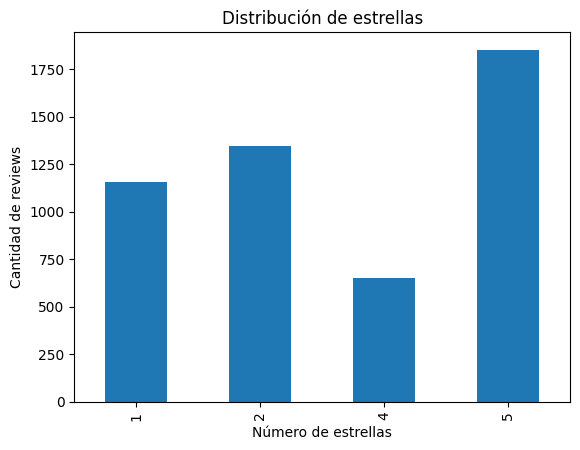

In [7]:
import matplotlib.pyplot as plt

df_small['overall'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de estrellas")
plt.xlabel("Número de estrellas")
plt.ylabel("Cantidad de reviews")
plt.show()


Preparo el texto de las reviews para poder usarlo en modelos de NLP. Primero defino una función tokenize que pasa el texto a minúsculas, elimina signos de puntuación con una expresión regular y divide la frase en tokens. Después aplico esa función a todas las reviews de df_small, junto todas las listas de tokens en una sola (all_tokens) y calculo el tamaño del vocabulario distinto. Esto me sirve para saber cuántas palabras únicas aparecen en mi conjunto de datos.


In [8]:
import re
from collections import Counter

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

tokens = df_small['reviewText'].dropna().apply(tokenize)

all_tokens = [token for sublist in tokens for token in sublist]

vocab = set(all_tokens)
len(vocab)


18248

Calculo la frecuencia de cada palabra en todas las reviews usando Counter. Luego muestro las 20 palabras más frecuentes. Esto se hace para entender qué términos aparecen más a menudo en el texto y tener una primera idea del vocabulario y posibles palabras poco informativas (the, and,etc...) y filtar más adelante

In [9]:
counter = Counter(all_tokens)
counter.most_common(20)


[('the', 26028),
 ('and', 14340),
 ('i', 14133),
 ('to', 13998),
 ('it', 13755),
 ('a', 11557),
 ('is', 7881),
 ('this', 7105),
 ('of', 6567),
 ('for', 6366),
 ('in', 5908),
 ('my', 5368),
 ('that', 5198),
 ('on', 4284),
 ('with', 4141),
 ('but', 4099),
 ('have', 3821),
 ('not', 3715),
 ('was', 3670),
 ('so', 3419)]

Construyo un WordCloud usando solo las reviews positivas. Primero uno todo el texto de las reseñas con sentiment == 1 en una sola cadena, y después genero un WordCloud para visualizar qué palabras aparecen con más frecuencia. La idea es tener una representación visual rápida de los términos más típicos en las opiniones positivas  y entender mejor qué valoran los usuarios cuando dejan buenas reviews. Hacemos lo mismo con las reviews negativas


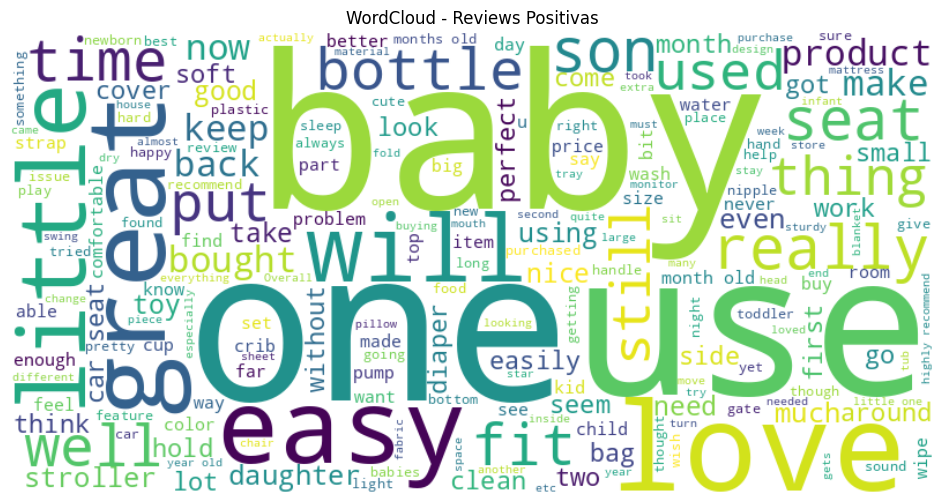

In [10]:
from wordcloud import WordCloud

text_pos = " ".join(df_small[df_small['sentiment']==1]['reviewText'].dropna())
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(text_pos)

plt.figure(figsize=(12,6))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Reviews Positivas")
plt.show()


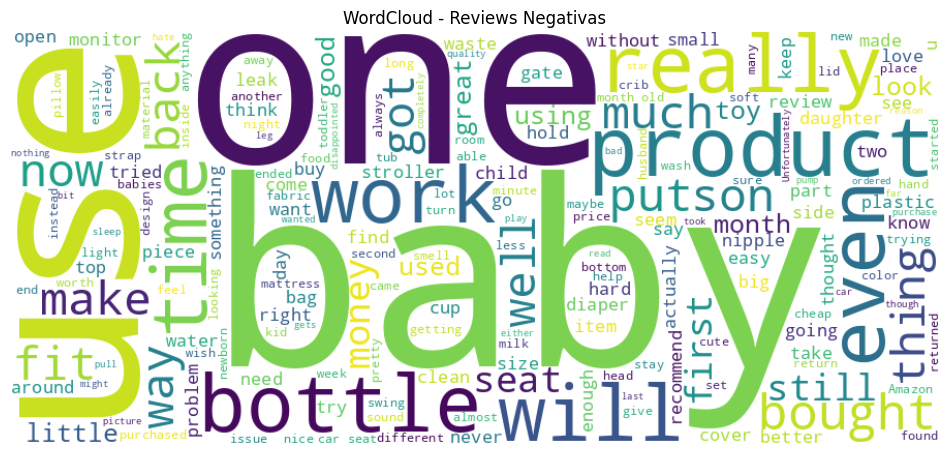

In [ ]:
text_neg = " ".join(df_small[df_small['sentiment']==0]['reviewText'])
wc = WordCloud(width=900, height=400, background_color="white").generate(text_neg)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Reviews Negativas")
plt.show()


In [11]:
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 94.1 MB/s eta 0:00:00


Entreno un modelo Word2Vec a partir de las reviews. Primero preparo la lista de frases tokenizadas usando la función tokenize. Después creo el modelo y lo guardo.


In [12]:
from gensim.models import Word2Vec

sentences = df_small['reviewText'].dropna().apply(tokenize)

model_w2v = Word2Vec(
    sentences,
    vector_size=50,
    window=5,
    min_count=5,
    workers=4,
    sg=1
)

model_w2v.save("word2vec_baby.model")


In [13]:
words = ["baby", "diaper", "bottle", "stroller"]


Exploro el modelo Word2Vec. Para cada palabra de la lista anterior, le pido al modelo las 10 palabras más similares según los vectores entrenados. Esto me permite comprobar que el modelo ha aprendido relaciones razonables y entender mejor cómo está representando el lenguaje de las reviews.


In [14]:
for w in words:
    print("\nPalabra:", w)
    print(model_w2v.wv.most_similar(w, topn=10))



Palabra: baby
[('child', 0.7666727900505066), ('newborns', 0.7562446594238281), ('daughter', 0.7233420610427856), ('niece', 0.7120577692985535), ('kid', 0.7096496224403381), ('sack', 0.7043083310127258), ('wubbanub', 0.6894109845161438), ('infants', 0.6812644600868225), ('swaddled', 0.680689811706543), ('babys', 0.6785277724266052)]

Palabra: diaper
[('bag', 0.8671866059303284), ('pail', 0.8307476043701172), ('champ', 0.8049386143684387), ('wet', 0.7935965061187744), ('genie', 0.792149543762207), ('cloth', 0.7920454144477844), ('diapers', 0.7904762625694275), ('trash', 0.7769811153411865), ('rash', 0.743308961391449), ('elite', 0.7383906245231628)]

Palabra: bottle
[('nipple', 0.85178542137146), ('bottles', 0.8456539511680603), ('milk', 0.8394085168838501), ('formula', 0.8299920558929443), ('brush', 0.8082761168479919), ('water', 0.7777697443962097), ('container', 0.7434250712394714), ('feeding', 0.7405418753623962), ('rack', 0.7254989743232727), ('drying', 0.7054534554481506)]

Palab

Preparo una visualización de las relaciones entre palabras aprendidas por el modelo Word2Vec. Primero creo una lista words_to_plot donde meto mis palabras base (baby, diaper, etc.) y, para cada una, añado también sus 10 palabras más similares según el modelo. Después obtengo los vectores de todas esas palabras y los guardo en X. Como esos vectores tienen muchas dimensiones, aplico PCA para reducirlos a solo 2 componentes (X_2d) y así poder representarlos en un plano.


In [15]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

words_to_plot = []

for w in words:
    words_to_plot.append(w)
    sim = model_w2v.wv.most_similar(w, topn=10)
    words_to_plot += [x[0] for x in sim]

X = np.array([model_w2v.wv[w] for w in words_to_plot])

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


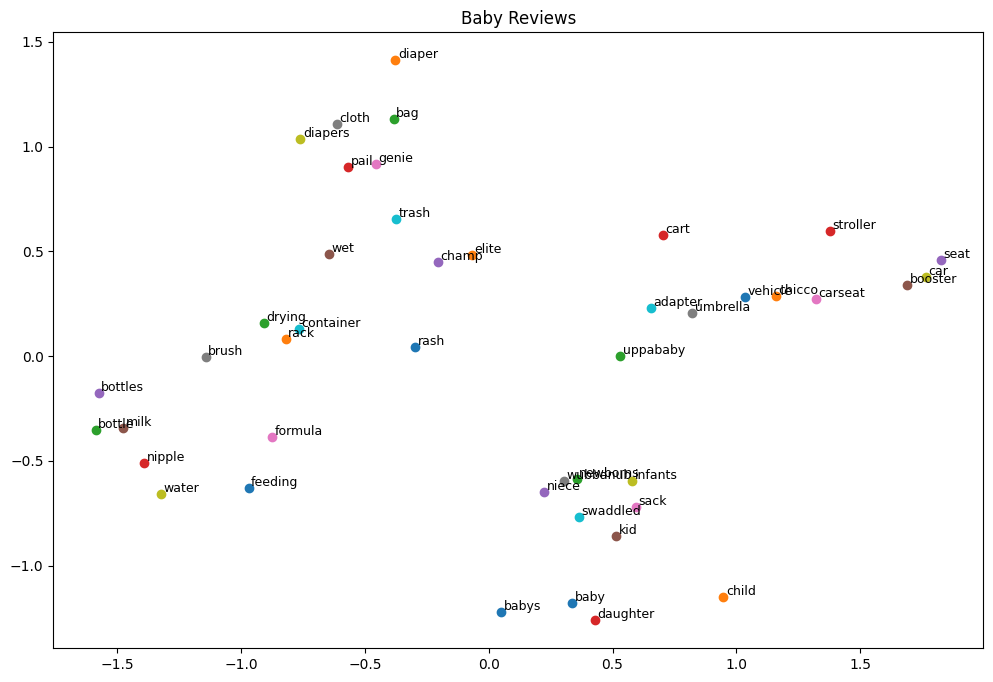

In [16]:
plt.figure(figsize=(12,8))

for i, word in enumerate(words_to_plot):
    x, y = X_2d[i,0], X_2d[i,1]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word, fontsize=9)

plt.title("Baby Reviews")
plt.show()


In [ ]:
df_small.to_csv("baby_reviews_small.csv", index=False)
